In [99]:
import pandas as pd
import math
import numpy as np

In [120]:
scores = pd.read_csv("data/merged.csv", index_col=0)
#scores["streamed_at"] = pd.to_datetime(scores["streamed_at"])
scores["streamed_at"] = pd.to_datetime(scores["streamed_at"], format='ISO8601')

In [141]:
# src/plotting.py

import logging
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

logger = logging.getLogger(__name__)

# --- Spotify Color Palette & Styles ---
SPOTIFY_GREEN = "#1DB954"
SPOTIFY_BLACK = "#121212"
SPOTIFY_WHITE = "#FFFFFF"
SPOTIFY_GREY = "#B3B3B3"
SPOTIFY_DARK_GREY = '#535353'

# A palette of accent colors for multi-line/bar charts
SPOTIFY_ACCENT_PALETTE = [
    "#1DB954",  # Green
    "#FFFFFF",  # White
    "#B3B3B3",  # Grey
    "#535353",  # Medium Grey
    "#F59B23",  # A yellow/orange accent they sometimes use
    "#E13300",  # A red/orange accent
]


def setup_plot_style():
    """
    Sets a global, professional, Spotify-themed style for all subsequent plots.

    This function configures matplotlib and seaborn to use a dark background,
    Spotify's color scheme, and professional-looking font styles. It should be
    called once before any plotting functions are invoked.
    """
    plt.style.use("dark_background")

    plt.rcParams.update({
        # --- Figure ---
        "figure.facecolor": SPOTIFY_BLACK,
        "figure.edgecolor": SPOTIFY_BLACK,
        "figure.figsize": (12, 8),

        # --- Axes ---
        "axes.facecolor": SPOTIFY_BLACK,
        "axes.edgecolor": SPOTIFY_GREY,
        "axes.labelcolor": SPOTIFY_WHITE,
        "axes.titlecolor": SPOTIFY_WHITE,
        "axes.titlesize": 20,
        "axes.labelsize": 14,

        # --- Ticks ---
        "xtick.color": SPOTIFY_GREY,
        "ytick.color": SPOTIFY_GREY,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,

        # --- Grid ---
        "grid.color": "#535353",
        "grid.linestyle": ":",
        "grid.linewidth": 0.5,

        # --- Legend ---
        "legend.facecolor": SPOTIFY_BLACK,
        "legend.edgecolor": SPOTIFY_GREY,
        "legend.fontsize": 12,
        "legend.title_fontsize": 14,

        # --- Text & Font ---
        "text.color": SPOTIFY_WHITE,
        "font.family": "sans-serif",
        "font.sans-serif": ["Helvetica", "Arial", "DejaVu Sans"], # Professional, clean fonts

        # --- Lines ---
        "lines.linewidth": 2,
    })
    logger.info("Spotify plot style configured globally.")


def save_plot(figure, file_path: str):
    """
    Saves a matplotlib figure to a file with optimized settings.

    Args:
        figure: The matplotlib figure object to save.
        file_path (str): The path (including filename and extension) to save the plot.
    """
    try:
        figure.savefig(file_path, dpi=300, bbox_inches="tight", facecolor=SPOTIFY_BLACK)
        logger.info(f"Plot successfully saved to {file_path}")
    except Exception as e:
        logger.error(f"Failed to save plot to {file_path}: {e}")
    plt.close(figure) # Close the figure to free up memory


# --- Example Plotting Functions ---

def plot_top_artists(artist_summary_df: pd.DataFrame, top_n: int = 10):
    """
    Generates and saves a bar chart of the top N artists by adjusted enjoyment.

    Args:
        artist_summary_df (pd.DataFrame): Aggregated DataFrame of artists.
        top_n (int, optional): The number of top artists to display. Defaults to 10.
    """
    if artist_summary_df.empty:
        logger.warning("Artist summary DataFrame is empty. Skipping top artists plot.")
        return

    top_artists = artist_summary_df.sort_values(
        "adjusted_enjoyment_score", ascending=False
    ).head(top_n)

    fig, ax = plt.subplots()

    sns.barplot(
        x="adjusted_enjoyment_score",
        y="album_artist",
        data=top_artists,
        color=SPOTIFY_GREEN,
        ax=ax,
    )

    ax.set_title(f"Top {top_n} Artists by Adjusted Enjoyment", pad=20)
    ax.set_xlabel("Adjusted Enjoyment Score")
    ax.set_ylabel("") # Artist names are clear enough, no need for a y-label
    sns.despine(ax=ax, left=True, bottom=True) # Remove top and right spines

    save_plot(fig, "reports/top_artists.png")


def plot_enjoyment_over_time(stream_level_df: pd.DataFrame, window: str = "90D"):
    """
    Generates and saves a time-series plot of rolling average enjoyment.

    Args:
        stream_level_df (pd.DataFrame): DataFrame with stream-level enjoyment scores.
        window (str, optional): The rolling window size (e.g., '30D', '90D'). Defaults to '90D'.
    """
    if stream_level_df.empty:
        logger.warning("Stream level DataFrame is empty. Skipping enjoyment over time plot.")
        return

    df_ts = stream_level_df.set_index("streamed_at").copy()

    rolling_enjoyment = df_ts["enjoyment_score_norm"].rolling(window=window).mean()

    fig, ax = plt.subplots()

    rolling_enjoyment.plot(ax=ax, color=SPOTIFY_GREEN, legend=False)
    
    # Add a horizontal line for the global average
    global_mean = stream_level_df["enjoyment_score_norm"].mean()
    ax.axhline(global_mean, color=SPOTIFY_GREY, linestyle="--", linewidth=1.5, label=f"Global Mean ({global_mean:.2f})")

    ax.set_title(f"Musical Enjoyment Over Time ({window} Rolling Average)", pad=20)
    ax.set_xlabel("")
    ax.set_ylabel("Normalized Enjoyment Score")
    ax.legend()
    sns.despine(ax=ax)

    save_plot(fig, "reports/enjoyment_over_time.png")

In [137]:
# In src/plotting.py

# ... (keep all your existing imports and setup code) ...

def plot_top_artists_infographic(artist_summary_df: pd.DataFrame, top_n: int = 5):
    """
    Generates and saves a standalone, infographic-style plot of top artists.

    This function moves beyond a simple bar chart to create a visually rich
    infographic that highlights key findings, using a Spotify-themed style.

    Args:
        artist_summary_df (pd.DataFrame): Aggregated DataFrame of artists.
        top_n (int, optional): The number of top artists to display.
                               A smaller number like 5 is better for this layout.
                               Defaults to 5.
    """
    if artist_summary_df.empty:
        logger.warning("Artist summary DataFrame is empty. Skipping infographic.")
        return

    # --- 1. Data Preparation ---
    # We will rank by enjoyment score, but the bar heights will be play count.
    top_artists = artist_summary_df.sort_values(
        "adjusted_enjoyment_score", ascending=False
    ).head(top_n)

    # --- 2. Setup the Figure ---
    # The global style is already set, but we can make specific adjustments.
    fig, ax = plt.subplots(figsize=(14, 8))
    fig.set_facecolor(SPOTIFY_BLACK)
    ax.set_facecolor(SPOTIFY_BLACK)

    # --- 3. Plot the Bars ---
    bars = ax.bar(
        x=top_artists["album_artist"],
        height=top_artists["play_count"],
        color=SPOTIFY_GREEN,
        width=0.6  # Make bars a bit narrower
    )

    # --- 4. De-clutter and Style the Axes ---
    # Remove all spines (the lines surrounding the plot)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Remove the y-axis completely
    ax.get_yaxis().set_visible(False)

    # Style the x-axis (artist names)
    ax.tick_params(
        axis='x',
        which='both',
        bottom=False, # No tick marks
        top=False,
        labelbottom=True,
        labelcolor=SPOTIFY_WHITE,
        pad=15, # Add padding between ticks and the plot
        labelsize=14
    )

    # --- 5. Add Annotations on Top of Bars ---
    #This is the key to the infographic style.
    for bar in bars:
        height = bar.get_height()
        ax.text(
            x=bar.get_x() + bar.get_width() / 2,
            y=height + (ax.get_ylim()[1] * 0.05), # Position just above the bar
            s=f'{int(height)}', # The text to display (play count)
            ha='center',
            va='bottom',
            fontsize=16,
            color=SPOTIFY_WHITE,
            weight='bold',
            # Add a white circle background for the text
            bbox=dict(
                facecolor=SPOTIFY_WHITE,
                edgecolor='none',
                boxstyle='circle,pad=0.4',
            ),
            # Set the text color inside the circle to black
            fontdict={'color': SPOTIFY_BLACK}
        )
    # Adjust y-limit to make space for the annotations
    ax.set_ylim(0, ax.get_ylim()[1] * 1.2)


    # --- 6. Add the Main Narrative Text (like the "133%") ---
    # Let's highlight the #1 artist.
    top_artist = top_artists.iloc[0]
    
    # We use fig.text for positioning relative to the whole figure (0-1 coords)
    fig.text(
        0.62, 0.65, # X, Y coordinates
        f"{top_artist.play_count}",
        ha='left',
        va='center',
        fontsize=100,
        weight='bold',
        color=SPOTIFY_GREEN
    )
    fig.text(
        0.62, 0.55,
        f"Total plays for your top artist,\n{top_artist.album_artist}, based on an\nadjusted enjoyment score of {top_artist.adjusted_enjoyment_score:.2f}.",
        ha='left',
        va='top',
        fontsize=16,
        color=SPOTIFY_GREY,
        linespacing=1.5
    )

    # --- 7. Add Title and Subtitle ---
    fig.text(
        0.1, 0.9,
        "TOP ARTIST REVIEW",
        ha='left',
        va='center',
        fontsize=24,
        weight='bold',
        color=SPOTIFY_WHITE
    )
    fig.text(
        0.1, 0.85,
        "A summary of your most-enjoyed artists by play count.",
        ha='left',
        va='center',
        fontsize=16,
        color=SPOTIFY_GREY
    )

    # --- 8. Save the Plot ---
    save_plot(fig, "reports/top_artists_infographic.png")

In [128]:
scores[scores.streamed_at == "2024-12-23 07:30:52+00:00"]

,streamed_at,track_name,album_name,album_artist,track_id,ms_played,ip_addr,reason_start,reason_end,shuffle,...,track_duration_ms,track_popularity,playlists,album_artwork_url,fraction_played,start_score,end_score,is_saved,enjoyment_score,enjoyment_score_norm
23422,2024-12-23 07:30:52+00:00,Stopped in Hell (feat. Lily Fitts),Restless Mind,Sam Barber,7tn1RIWpGi1JENED23TFEZ,20.0,80.233.57.254,clickrow,endplay,True,...,213295,55,[],https://i.scdn.co/image/ab67616d0000b273c944a2...,0.000094,1.0,0.0,False,0.000094,0.332870
23423,2024-12-23 07:30:52+00:00,Stopped in Hell (feat. Lily Fitts),Restless Mind,Sam Barber,7tn1RIWpGi1JENED23TFEZ,0.0,80.233.57.254,clickrow,endplay,True,...,213295,55,[],https://i.scdn.co/image/ab67616d0000b273c944a2...,0.000000,1.0,0.0,False,0.000000,0.332855
23424,2024-12-23 07:30:52+00:00,Stopped in Hell (feat. Lily Fitts),Restless Mind,Sam Barber,7tn1RIWpGi1JENED23TFEZ,0.0,80.233.57.254,clickrow,endplay,True,...,213295,55,[],https://i.scdn.co/image/ab67616d0000b273c944a2...,0.000000,1.0,0.0,False,0.000000,0.332855
23425,2024-12-23 07:30:52+00:00,Stopped in Hell (feat. Lily Fitts),Restless Mind,Sam Barber,7tn1RIWpGi1JENED23TFEZ,0.0,80.233.57.254,clickrow,endplay,True,...,213295,55,[],https://i.scdn.co/image/ab67616d0000b273c944a2...,0.000000,1.0,0.0,False,0.000000,0.332855
23426,2024-12-23 07:30:52+00:00,Stopped in Hell (feat. Lily Fitts),Restless Mind,Sam Barber,7tn1RIWpGi1JENED23TFEZ,0.0,80.233.57.254,clickrow,endplay,True,...,213295,55,[],https://i.scdn.co/image/ab67616d0000b273c944a2...,0.000000,1.0,0.0,False,0.000000,0.332855
23427,2024-12-23 07:30:52+00:00,Stopped in Hell (feat. Lily Fitts),Restless Mind,Sam Barber,7tn1RIWpGi1JENED23TFEZ,10.0,80.233.57.254,clickrow,endplay,True,...,213295,55,[],https://i.scdn.co/image/ab67616d0000b273c944a2...,0.000047,1.0,0.0,False,0.000047,0.332862
23428,2024-12-23 07:30:52+00:00,Stopped in Hell (feat. Lily Fitts),Restless Mind,Sam Barber,7tn1RIWpGi1JENED23TFEZ,0.0,80.233.57.254,clickrow,endplay,True,...,213295,55,[],https://i.scdn.co/image/ab67616d0000b273c944a2...,0.000000,1.0,0.0,False,0.000000,0.332855
23429,2024-12-23 07:30:52+00:00,Stopped in Hell (feat. Lily Fitts),Restless Mind,Sam Barber,7tn1RIWpGi1JENED23TFEZ,0.0,80.233.57.254,clickrow,endplay,True,...,213295,55,[],https://i.scdn.co/image/ab67616d0000b273c944a2...,0.000000,1.0,0.0,False,0.000000,0.332855
23430,2024-12-23 07:30:52+00:00,Stopped in Hell (feat. Lily Fitts),Restless Mind,Sam Barber,7tn1RIWpGi1JENED23TFEZ,0.0,80.233.57.254,clickrow,endplay,True,...,213295,55,[],https://i.scdn.co/image/ab67616d0000b273c944a2...,0.000000,1.0,0.0,False,0.000000,0.332855
23431,2024-12-23 07:30:52+00:00,Home Ain't Far,Restless Mind,Sam Barber,5doJY9J5jp04ItrLlMASRQ,166228.0,80.233.57.254,trackdone,endplay,True,...,195888,49,[],https://i.scdn.co/image/ab67616d0000b273c944a2...,0.848587,0.0,0.0,False,-0.151413,0.307601


In [127]:
scores["streamed_at"].value_counts()

streamed_at
2024-12-23 07:30:52+00:00           11
2024-10-26 13:31:53+00:00            4
2024-01-04 21:05:49+00:00            4
2024-01-04 21:05:47+00:00            4
2024-04-17 07:56:35+00:00            4
                                    ..
2024-07-02 19:54:43+00:00            1
2024-07-02 19:54:42+00:00            1
2024-07-02 19:54:40+00:00            1
2024-07-02 19:54:39+00:00            1
2025-05-09 13:04:50.782000+00:00     1
Name: count, Length: 34446, dtype: int64

In [129]:
plot_top_artists(scores)

KeyError: 'adjusted_enjoyment_score'

In [174]:
track_df = pd.read_csv("data/scored_tracks.csv", index_col=0)

In [132]:
plot_top_artists(track_df)

In [138]:
plot_top_artists_infographic(track_df)

In [175]:
track_df.loc[0]

track_name                                                       ! Basta Ya !
album_artist                                        La Familia Valera Miranda
mean_enjoyment_score                                                 0.556401
play_count                                                                  3
first_listen                                        2024-07-08 10:49:08+00:00
last_listen                                         2024-07-10 07:49:40+00:00
album_artwork_url           https://i.scdn.co/image/ab67616d0000b2734bace4...
adjusted_enjoyment_score                                             0.447292
Name: 0, dtype: object

In [154]:
def plot_top_track_infographic(track_summary_df: pd.DataFrame, top_n: int = 10):
    """
    Alternative version with horizontal bars for better label readability.
    """
    if track_summary_df.empty:
        print("Track summary DataFrame is empty. Skipping infographic.")
        return

    # Data preparation
    top_tracks = track_summary_df.sort_values(
        "adjusted_enjoyment_score", ascending=False
    ).head(top_n).reset_index(drop=True)

    # Setup figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), 
                                   gridspec_kw={'width_ratios': [2, 1]})
    fig.set_facecolor(SPOTIFY_BLACK)
    
    for ax in [ax1, ax2]:
        ax.set_facecolor(SPOTIFY_BLACK)
        for spine in ax.spines.values():
            spine.set_visible(False)

    # Horizontal bar chart
    y_positions = np.arange(len(top_tracks))
    bars = ax1.barh(
        y=y_positions,
        width=top_tracks["adjusted_enjoyment_score"],
        color=SPOTIFY_GREEN,
        height=0.6,
        alpha=0.9
    )

    # Style the chart
    ax1.set_yticks(y_positions)
    ax1.set_yticklabels(top_tracks["track_name"]+" - "+top_tracks["album_artist"], fontsize=12, color=SPOTIFY_WHITE)
    ax1.get_xaxis().set_visible(False)
    ax1.invert_yaxis()  # Top artist at the top

    # Add value labels
    for bar, enjoyment_score in zip(bars, top_tracks["adjusted_enjoyment_score"]):
        ax1.text(
            bar.get_width() + max(top_tracks["adjusted_enjoyment_score"]) * 0.01,
            bar.get_y() + bar.get_height()/2,
            f'{round(enjoyment_score, 3)}',
            ha='left',
            va='center',
            fontsize=14,
            color=SPOTIFY_WHITE,
            weight='bold'
        )

    # Title
    ax1.text(0.02, 0.98, "TOP TRACKS", transform=ax1.transAxes,
             fontsize=24, weight='bold', color=SPOTIFY_WHITE, va='top')
    ax1.text(0.02, 0.91, "Most enjoyed by enjoyment score", transform=ax1.transAxes,
             fontsize=14, color=SPOTIFY_GREY, va='top')

    # Remove the second axis and use figure text for the narrative
    ax2.set_visible(False)
    
    # Big number and description
    top_track = top_tracks.iloc[0]
    fig.text(0.75, 0.6, f"{round(top_track['adjusted_enjoyment_score'], 3)}", 
             fontsize=72, weight='bold', color=SPOTIFY_GREEN, ha='center')
    
    fig.text(0.75, 0.4, f"{top_track['track_name']}", 
             fontsize=16, color=SPOTIFY_GREY, ha='center')
    
    fig.text(0.75, 0.3, f"{top_track['album_artist']}", 
             fontsize=14, color=SPOTIFY_DARK_GREY, ha='center')

    # Save
    try:
        save_plot(fig, "reports/top_tracks_infographic.png")
    except NameError:
        plt.savefig("reports/top_tracks_infographic.png", 
                   facecolor=SPOTIFY_BLACK, dpi=300, bbox_inches='tight')
    
    plt.show()

In [155]:
plot_top_track_infographic(track_df)

In [226]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle, FancyBboxPatch
from datetime import datetime
import textwrap
import urllib.request
from PIL import Image
import urllib.request
from io import BytesIO

# Professional color palette
COLORS = {
    'primary_black': '#0B0B0B',
    'spotify_green': '#1ED760',
    'accent_green': '#1DB954',
    'white': '#FFFFFF',
    'light_grey': '#E1E1E1',
    'medium_grey': '#B3B3B3',
    'dark_grey': '#404040',
    'card_bg': '#1A1A1A',
    'subtle_accent': '#2A2A2A',
    'fuchsia': "#f037a5"
}

def truncate_text(text, max_length=25):
    """Truncate text if too long and add ellipsis."""
    return text if len(text) <= max_length else text[:max_length-3] + "..."

# --- Helper function to fetch image ---
def get_image_from_url(url):
    with urllib.request.urlopen(url) as u:
        return Image.open(BytesIO(u.read()))

def create_professional_infographic(track_summary_df: pd.DataFrame, top_n: int = 10):
    """
    Professional infographic with proper spacing, no overlapping text, and clean design.
    """
    if track_summary_df.empty:
        print("Track summary DataFrame is empty. Skipping infographic.")
        return

    # Data preparation
    top_tracks = track_summary_df.sort_values(
        "adjusted_enjoyment_score", ascending=False
    ).head(top_n).reset_index(drop=True)
    
    # Calculate dynamic figure height based on content
    base_height = 10
    content_height = max(0.6 * top_n, 6)  # Ensure minimum height
    fig_height = base_height + content_height * 0.3
    
    # Create figure with calculated proportions
    fig = plt.figure(figsize=(18, fig_height))
    fig.set_facecolor(COLORS['primary_black'])
    
    # Create responsive grid layout
    gs = fig.add_gridspec(3, 3, 
                         height_ratios=[0.6, 3, 0.4], 
                         width_ratios=[2.2, 1, 0.3], 
                         hspace=0.15, wspace=0.1,
                         left=0.05, right=0.95, top=0.95, bottom=0.05)
    
    # Header section
    header_ax = fig.add_subplot(gs[0, :2])
    header_ax.set_facecolor(COLORS['primary_black'])
    header_ax.axis('off')
    
    # Main chart
    main_ax = fig.add_subplot(gs[1, 0])
    main_ax.set_facecolor(COLORS['primary_black'])
    
    # Stats panel  
    stats_ax = fig.add_subplot(gs[1, 1])
    stats_ax.set_facecolor(COLORS['primary_black'])
    stats_ax.axis('off')
    
    # Footer
    footer_ax = fig.add_subplot(gs[2, :2])
    footer_ax.set_facecolor(COLORS['primary_black'])
    footer_ax.axis('off')
    
    # Remove all spines
    for spine in main_ax.spines.values():
        spine.set_visible(False)
    
    # === HEADER SECTION ===
    # Main title with accent
    header_ax.text(0.0, 0.7, "YOUR TOP TRACKS", 
                   fontsize=32, weight='bold', color=COLORS['white'])
    
    # Subtitle
    header_ax.text(0.0, 0.3, "Ranked by Personal Enjoyment Score", 
                   fontsize=16, color=COLORS['medium_grey'])
    
    # Decorative accent bar
    header_ax.add_patch(Rectangle((0, 0), 0.32, 0.08, 
                                 facecolor=COLORS['fuchsia'], 
                                 transform=header_ax.transAxes))
    
    # === MAIN CHART ===
    y_positions = np.arange(len(top_tracks))
    bar_height = 0.75
    
    # Create clean bars with proper spacing
    bars = []
    for i, (_, track) in enumerate(top_tracks.iterrows()):
        score = track["adjusted_enjoyment_score"]
        
        # Single clean bar - no background clutter
        bar = main_ax.barh(y_positions[i], score, height=bar_height, 
                          color=COLORS['spotify_green'], alpha=0.95,
                          edgecolor=COLORS['accent_green'], linewidth=0.5)
        bars.append(bar)
    
    # Prepare labels with proper formatting and truncation
    track_labels = []
    for _, track in top_tracks.iterrows():
        track_name = truncate_text(str(track['track_name']), 30)
        artist_name = truncate_text(str(track['album_artist']), 25)
        track_labels.append(f"{track_name}\n{artist_name}")
    
    # Set labels with calculated spacing
    main_ax.set_yticks(y_positions)
    main_ax.set_yticklabels(track_labels, fontsize=11, color=COLORS['white'],
                           verticalalignment='center')
    main_ax.get_xaxis().set_visible(False)
    main_ax.invert_yaxis()
    
    # Add rank numbers with proper positioning
    for i in range(len(top_tracks)):
        main_ax.text(-0.15, y_positions[i], f'#{i+1}',
                    ha='center', va='center', fontsize=13, weight='bold',
                    color=COLORS['spotify_green'])
    
    # Add score labels with smart positioning
    max_score = top_tracks["adjusted_enjoyment_score"].max()
    for i, (_, track) in enumerate(top_tracks.iterrows()):
        score = track["adjusted_enjoyment_score"]
        # Position labels outside bars with consistent spacing
        x_pos = max_score + 0.05
        main_ax.text(x_pos, y_positions[i], f'{score:.3f}',
                    ha='left', va='center', fontsize=12, weight='bold',
                    color=COLORS['white'])
    
    # Set proper axis limits to prevent overlap
    main_ax.set_xlim(-0.2, max_score + 0.2)
    main_ax.set_ylim(-0.5, len(top_tracks) - 0.5)
    
    # === STATS PANEL ===
    # Create card background
    card_bg = FancyBboxPatch((0.05, 0.05), 0.9, 0.9,
                            boxstyle="round,pad=0.02",
                            facecolor=COLORS['card_bg'],
                            edgecolor=COLORS['dark_grey'],
                            linewidth=1,
                            transform=stats_ax.transAxes)
    stats_ax.add_patch(card_bg)
    
    # Top track highlight
    top_track = top_tracks.iloc[0]
    
    # Large score display
    stats_ax.text(0.5, 0.7, f"{top_track['adjusted_enjoyment_score']:.3f}", 
                 fontsize=35, weight='bold', color=COLORS['spotify_green'], 
                 ha='center', transform=stats_ax.transAxes)
    
    stats_ax.text(0.5, 0.8, "HIGHEST SCORE", fontsize=11, weight='bold',
                 color=COLORS['medium_grey'], ha='center', transform=stats_ax.transAxes)
    
    # Add Image
    # Add Album Artwork Image
    try:
        top_img = get_image_from_url(top_track['album_artwork_url'])
        # Create a square image area positioned to the left
        img_ax = fig.add_axes([
            stats_ax.get_position().x0 + 0.06,  # X position (left side of card)
            stats_ax.get_position().y0 + 0.28,  # Y position (middle area)
            0.12,  # Width (square)
            0.12   # Height (square)
        ])
        img_ax.imshow(top_img)
        img_ax.axis('off')
        
        # Add subtle border around image
        img_border = FancyBboxPatch((0, 0), 1, 1,
                                boxstyle="round,pad=0.02",
                                facecolor='none',
                                edgecolor=COLORS['dark_grey'],
                                linewidth=1,
                                transform=img_ax.transAxes)
        img_ax.add_patch(img_border)
        
        # Adjust text positioning to accommodate image 
        text_y_pos = 0.4  # Move text to the right
        
    except Exception as e:
        print(f"Could not load album artwork: {e}")
        # Increase Hieght of text if no image
        text_y_pos = 0.55

    
    # Top track info with better formatting
    track_name_display = truncate_text(str(top_track["track_name"]), 20)
    artist_name_display = truncate_text(str(top_track["album_artist"]), 18)
    
    stats_ax.text(0.5, text_y_pos, f'"{track_name_display}"', fontsize=13, 
                 color=COLORS['white'], ha='center', weight='bold',
                 transform=stats_ax.transAxes, style='italic')
    
    stats_ax.text(0.5, text_y_pos-0.03, artist_name_display, fontsize=11, 
                 color=COLORS['medium_grey'], ha='center', transform=stats_ax.transAxes)
    
    # Additional contextual stats
    total_tracks = len(track_summary_df)
    avg_score = track_summary_df['adjusted_enjoyment_score'].mean()
    score_range = (track_summary_df['adjusted_enjoyment_score'].max() - 
                   track_summary_df['adjusted_enjoyment_score'].min())
    
    # Clean stats display
    stats_items = [
        ("TOTAL ANALYZED", f"{total_tracks:,}"),
        ("AVERAGE SCORE", f"{avg_score:.3f}"),
        ("SCORE RANGE", f"{score_range:.3f}")
    ]
    
    y_positions_stats = [0.32, 0.22, 0.12]
    for i, (label, value) in enumerate(stats_items):
        y_pos = y_positions_stats[i]
        stats_ax.text(0.5, y_pos, value, fontsize=14, weight='bold',
                     color=COLORS['spotify_green'], ha='center', 
                     transform=stats_ax.transAxes)
        stats_ax.text(0.5, y_pos - 0.04, label, fontsize=9,
                     color=COLORS['medium_grey'], ha='center', 
                     transform=stats_ax.transAxes)
    
    # === FOOTER SECTION ===
    # Left side: methodology
    footer_ax.text(0.0, 0.8, "METHODOLOGY", fontsize=10, weight='bold',
                  color=COLORS['medium_grey'])
    
    methodology_text = ("Enjoyment Score combines listening frequency, completion rates, and user engagement patterns. "
                       "Scores range from 0-1, with higher values indicating stronger personal connection to tracks.")
    
    # Wrap text properly
    wrapped_text = textwrap.fill(methodology_text, width=80)
    footer_ax.text(0.0, 0.25, wrapped_text, fontsize=9, 
                  color=COLORS['dark_grey'], linespacing=1.5)
    
    # Right side: generation info
    current_date = datetime.now().strftime("%B %Y")
    footer_ax.text(1.0, 0.8, f"Generated: {current_date}", fontsize=9,
                  color=COLORS['medium_grey'], ha='right')
    
    footer_ax.text(1.0, 0.5, "Data Source: Spotify Listening History", fontsize=9,
                  color=COLORS['dark_grey'], ha='right')
    
    # === FINAL STYLING ===
    # Add subtle grid for reference (optional)
    for x in np.linspace(0, max_score, 5):
        if x > 0:
            main_ax.axvline(x, color=COLORS['dark_grey'], alpha=0.2, linewidth=0.5, linestyle='--')
    
    # Ensure tight layout
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    
    # Save with high quality
    try:
        plt.savefig("reports/professional_top_tracks_infographic.png", 
                   facecolor=COLORS['primary_black'], dpi=300, bbox_inches='tight',
                   edgecolor='none', pad_inches=0.1)
        print("Infographic saved successfully to reports/professional_top_tracks_infographic.png")
    except Exception as e:
        print(f"Error saving file: {e}")
    
    plt.show()

# Example usage:
# create_professional_infographic(track_summary_df, top_n=10)

Infographic saved successfully to reports/professional_top_tracks_infographic.png


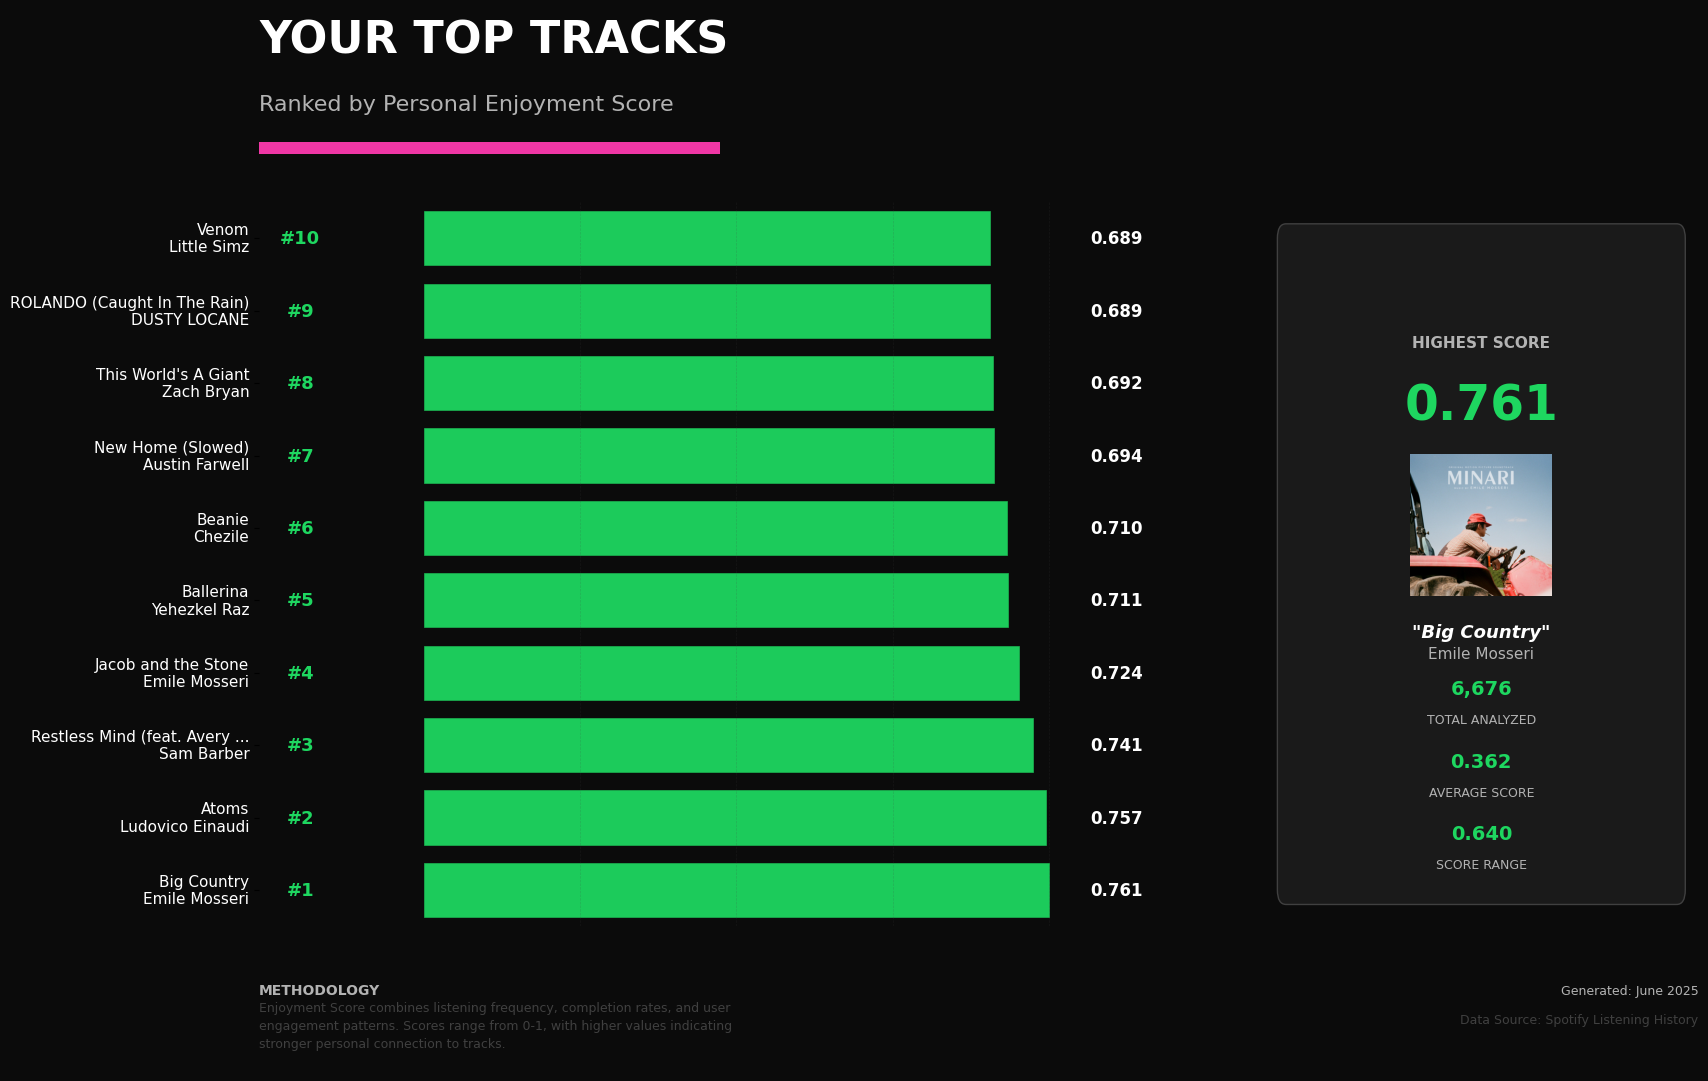

In [227]:
create_professional_infographic(track_df)

In [230]:
# src/infographics.py

"""
Generates high-quality, standalone infographic visualizations from analysis data.

This module is dedicated to creating bespoke, presentation-ready infographics
that go beyond standard charts. It uses matplotlib's lower-level APIs to gain
fine-grained control over layout, text, and design elements, producing a
professional and narrative-driven visual output.

The functions here are designed to be called at the end of the analysis
pipeline, taking a processed and aggregated DataFrame as input.
"""

import logging
from datetime import datetime
from io import BytesIO
from typing import Dict, Any
import textwrap
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.patches import Rectangle, FancyBboxPatch
from PIL import Image

logger = logging.getLogger(__name__)

# Professional color palette, defined as a module-level constant.
INFOGRAPHIC_COLORS: Dict[str, str] = {
    'primary_black': '#0B0B0B',
    'spotify_green': '#1ED760',
    'accent_green': '#1DB954',
    'white': '#FFFFFF',
    'light_grey': '#E1E1E1',
    'medium_grey': '#B3B3B3',
    'dark_grey': '#404040',
    'card_bg': '#1A1A1A',
    'subtle_accent': '#2A2A2A',
    'fuchsia': "#f037a5"
}


def _truncate_text(text: str, max_length: int = 25) -> str:
    """Truncates text with an ellipsis if it exceeds the maximum length."""
    return text if len(text) <= max_length else text[:max_length-3] + "..."


def _get_image_from_url(url: str) -> Image:
    """Fetches and opens an image from a given URL."""
    with urllib.request.urlopen(url) as u:
        return Image.open(BytesIO(u.read()))


def _plot_header(ax: Axes) -> None:
    """Draws the header section of the infographic."""
    ax.set_facecolor(INFOGRAPHIC_COLORS['primary_black'])
    ax.axis('off')
    ax.text(0.0, 0.7, "YOUR TOP TRACKS", fontsize=32, weight='bold', color=INFOGRAPHIC_COLORS['white'])
    ax.text(0.0, 0.3, "Ranked by Personal Enjoyment Score", fontsize=16, color=INFOGRAPHIC_COLORS['medium_grey'])
    ax.add_patch(Rectangle((0, 0), 0.32, 0.08, facecolor=INFOGRAPHIC_COLORS['fuchsia'], transform=ax.transAxes))


def _plot_footer(ax: Axes) -> None:
    """Draws the footer section of the infographic."""
    ax.set_facecolor(INFOGRAPHIC_COLORS['primary_black'])
    ax.axis('off')

    ax.text(0.0, 0.8, "METHODOLOGY", fontsize=10, weight='bold', color=INFOGRAPHIC_COLORS['medium_grey'])
    methodology_text = (
        "Enjoyment Score combines listening frequency, completion rates, and user engagement patterns. "
        "Scores are normalized, with higher values indicating stronger personal connection to tracks."
    )
    wrapped_text = textwrap.fill(methodology_text, width=80)
    ax.text(0.0, 0.25, wrapped_text, fontsize=9, color=INFOGRAPHIC_COLORS['dark_grey'], linespacing=1.5)

    current_date = datetime.now().strftime("%B %Y")
    ax.text(1.0, 0.8, f"Generated: {current_date}", fontsize=9, color=INFOGRAPHIC_COLORS['medium_grey'], ha='right')
    ax.text(1.0, 0.5, "Data Source: Spotify Listening History", fontsize=9, color=INFOGRAPHIC_COLORS['dark_grey'], ha='right')


def _plot_main_chart(ax: Axes, top_tracks: pd.DataFrame) -> None:
    """Draws the main horizontal bar chart of top tracks."""
    ax.set_facecolor(INFOGRAPHIC_COLORS['primary_black'])
    for spine in ax.spines.values():
        spine.set_visible(False)

    y_positions = np.arange(len(top_tracks))
    bar_height = 0.75

    # Plot bars
    ax.barh(
        y_positions,
        top_tracks["adjusted_enjoyment_score"],
        height=bar_height,
        color=INFOGRAPHIC_COLORS['spotify_green'],
        alpha=0.95,
        edgecolor=INFOGRAPHIC_COLORS['accent_green'],
        linewidth=0.5
    )

    # Format and set labels
    track_labels = [
        f"{_truncate_text(str(row.track_name), 30)}\n{_truncate_text(str(row.album_artist), 25)}"
        for _, row in top_tracks.iterrows()
    ]
    ax.set_yticks(y_positions)
    ax.set_yticklabels(track_labels, fontsize=11, color=INFOGRAPHIC_COLORS['white'], verticalalignment='center')
    ax.get_xaxis().set_visible(False)
    ax.invert_yaxis()

    # Add rank and score annotations
    max_score = top_tracks["adjusted_enjoyment_score"].max()
    for i, row in top_tracks.iterrows():
        score = row["adjusted_enjoyment_score"]
        ax.text(-0.15, y_positions[i], f'#{i+1}', ha='center', va='center', fontsize=13, weight='bold', color=INFOGRAPHIC_COLORS['spotify_green'])
        ax.text(max_score + 0.05, y_positions[i], f'{score:.3f}', ha='left', va='center', fontsize=12, weight='bold', color=INFOGRAPHIC_COLORS['white'])

    # Final styling
    ax.set_xlim(-0.2, max_score + 0.2)
    ax.set_ylim(-0.5, len(top_tracks) - 0.5)
    for x_val in np.linspace(0, max_score, 5):
        if x_val > 0:
            ax.axvline(x_val, color=INFOGRAPHIC_COLORS['dark_grey'], alpha=0.2, linewidth=0.5, linestyle='--')


def _plot_stats_panel(fig: Figure, ax: Axes, top_track: pd.Series, track_summary_df: pd.DataFrame) -> None:
    """Draws the statistics panel card."""
    ax.set_facecolor(INFOGRAPHIC_COLORS['primary_black'])
    ax.axis('off')

    # Card background
    card_bg = FancyBboxPatch((0.05, 0.05), 0.9, 0.9, boxstyle="round,pad=0.02", facecolor=INFOGRAPHIC_COLORS['card_bg'],
                             edgecolor=INFOGRAPHIC_COLORS['dark_grey'], linewidth=1, transform=ax.transAxes)
    ax.add_patch(card_bg)

    # Top track score
    ax.text(0.5, 0.8, "HIGHEST SCORE", fontsize=11, weight='bold', color=INFOGRAPHIC_COLORS['medium_grey'], ha='center', transform=ax.transAxes)
    ax.text(0.5, 0.7, f"{top_track['adjusted_enjoyment_score']:.3f}", fontsize=35, weight='bold', color=INFOGRAPHIC_COLORS['spotify_green'], ha='center', transform=ax.transAxes)

    # Album artwork
    text_y_pos = 0.55  # Default y-position for text if image fails
    try:
        top_img = _get_image_from_url(top_track['album_artwork_url'])
        img_ax = fig.add_axes([ax.get_position().x0 + 0.06, ax.get_position().y0 + 0.28, 0.12, 0.12])
        img_ax.imshow(top_img)
        img_ax.axis('off')
        img_border = FancyBboxPatch((0, 0), 1, 1, boxstyle="round,pad=0.02", facecolor='none', edgecolor=INFOGRAPHIC_COLORS['dark_grey'], linewidth=1, transform=img_ax.transAxes)
        img_ax.add_patch(img_border)
        text_y_pos = 0.4  # Adjust text position to make space for image
    except Exception as e:
        logger.warning(f"Could not load album artwork for stats panel: {e}")

    # Top track details
    track_name_display = _truncate_text(str(top_track["track_name"]), 20)
    artist_name_display = _truncate_text(str(top_track["album_artist"]), 18)
    ax.text(0.5, text_y_pos, f'"{track_name_display}"', fontsize=13, color=INFOGRAPHIC_COLORS['white'], ha='center', weight='bold', transform=ax.transAxes, style='italic')
    ax.text(0.5, text_y_pos - 0.05, artist_name_display, fontsize=11, color=INFOGRAPHIC_COLORS['medium_grey'], ha='center', transform=ax.transAxes)

    # Summary statistics
    total_tracks = len(track_summary_df)
    avg_score = track_summary_df['adjusted_enjoyment_score'].mean()
    stats_items = [("TOTAL ANALYZED", f"{total_tracks:,}"), ("AVERAGE SCORE", f"{avg_score:.3f}")]
    for i, (label, value) in enumerate(stats_items):
        y_pos = 0.32 - (i * 0.1)
        ax.text(0.5, y_pos, value, fontsize=14, weight='bold', color=INFOGRAPHIC_COLORS['spotify_green'], ha='center', transform=ax.transAxes)
        ax.text(0.5, y_pos - 0.04, label, fontsize=9, color=INFOGRAPHIC_COLORS['medium_grey'], ha='center', transform=ax.transAxes)


def plot_top_tracks_infographic(track_summary_df: pd.DataFrame, top_n: int = 10, save_path: str = "reports/top_tracks_infographic.png"):
    """
    Generates a professional, multi-part infographic for top tracks.

    This function orchestrates the creation of a complex visualization by
    delegating the drawing of each component (header, chart, stats, footer)
    to specialized helper functions.

    Args:
        track_summary_df (pd.DataFrame): Aggregated DataFrame of tracks, sorted
            by enjoyment score.
        top_n (int, optional): The number of top tracks to display. Defaults to 10.
        save_path (str, optional): The path to save the generated image file.
            Defaults to "reports/top_tracks_infographic.png".
    """
    if track_summary_df.empty:
        logger.warning("Track summary DataFrame is empty. Skipping infographic generation.")
        return

    top_tracks = track_summary_df.sort_values("adjusted_enjoyment_score", ascending=False).head(top_n).reset_index()

    fig_height = 10 + max(0.6 * top_n, 6) * 0.3
    fig = plt.figure(figsize=(18, fig_height))
    fig.set_facecolor(INFOGRAPHIC_COLORS['primary_black'])

    gs = fig.add_gridspec(3, 3, height_ratios=[0.6, 3, 0.4], width_ratios=[2.2, 1, 0.3],
                         hspace=0.15, wspace=0.1, left=0.05, right=0.95, top=0.95, bottom=0.05)

    # --- Call helper functions to draw each section ---
    _plot_header(fig.add_subplot(gs[0, :2]))
    _plot_main_chart(fig.add_subplot(gs[1, 0]), top_tracks)
    _plot_stats_panel(fig, fig.add_subplot(gs[1, 1]), top_tracks.iloc[0], track_summary_df)
    _plot_footer(fig.add_subplot(gs[2, :2]))

    try:
        plt.savefig(
            save_path,
            facecolor=INFOGRAPHIC_COLORS['primary_black'],
            dpi=300,
            bbox_inches='tight',
            edgecolor='none',
            pad_inches=0.1
        )
        logger.info(f"Infographic saved successfully to {save_path}")
    except Exception as e:
        logger.error(f"Failed to save infographic to {save_path}: {e}")
    finally:
        plt.close(fig) # Ensure the figure is closed to free memory

In [231]:
plot_top_tracks_infographic(track_df)

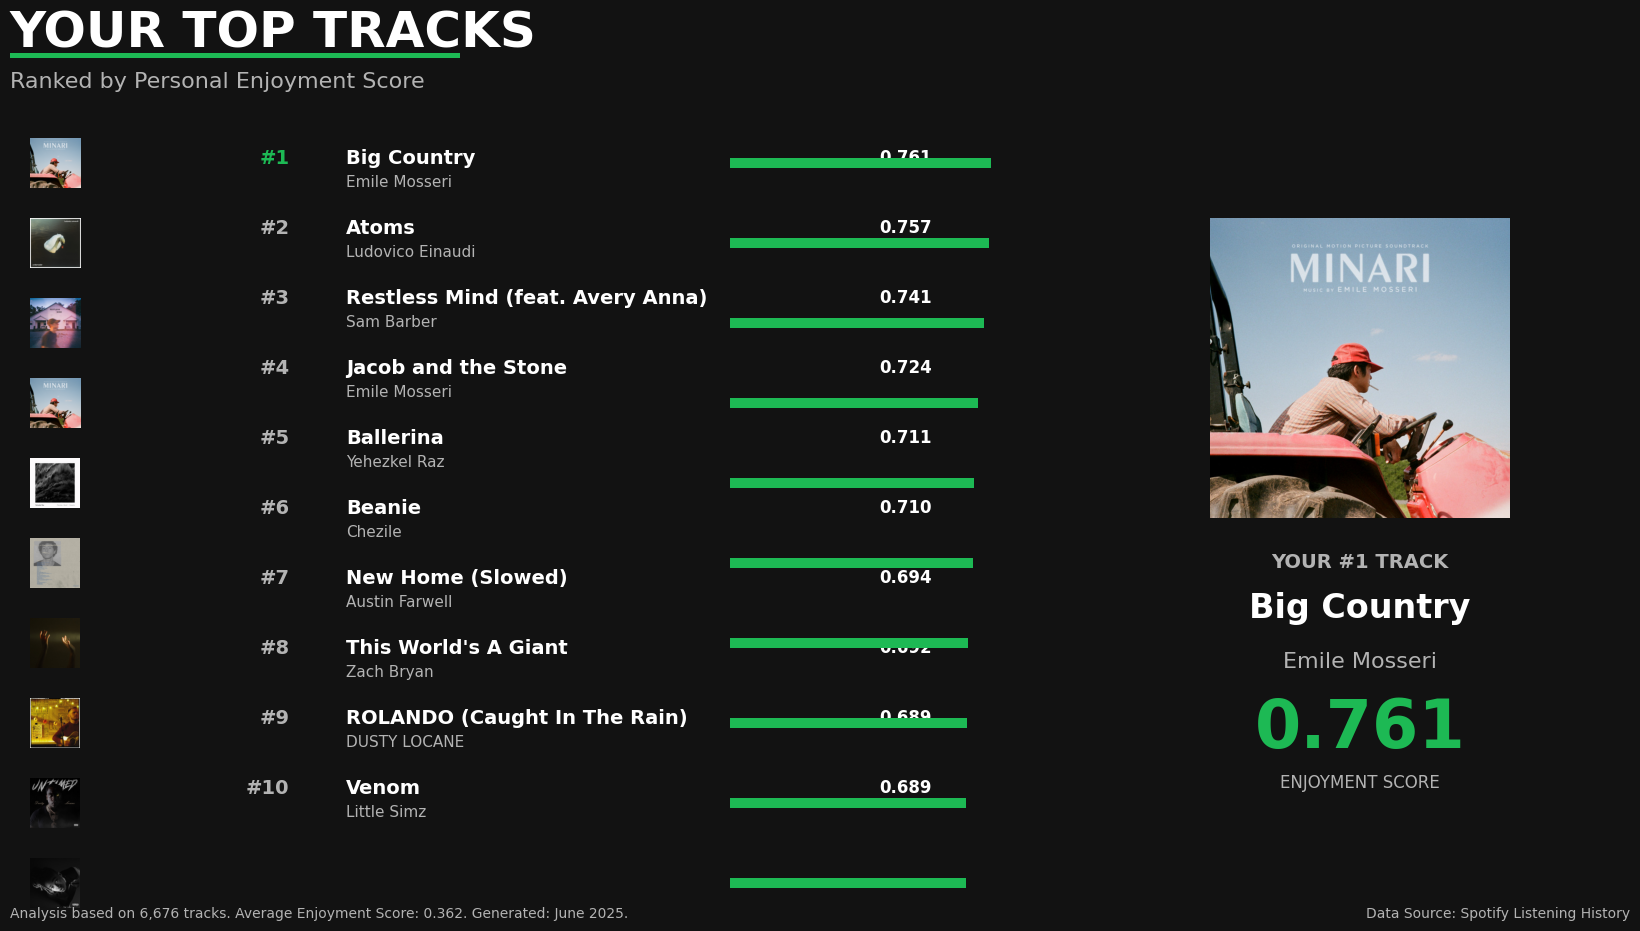

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
import urllib.request
from io import BytesIO

# --- Assuming SPOTIFY_BLACK, etc. are defined ---
SPOTIFY_BLACK = '#121212'
SPOTIFY_GREEN = '#1DB954'
SPOTIFY_WHITE = '#FFFFFF'
SPOTIFY_GREY = '#B3B3B3'
SPOTIFY_DARK_GREY = '#535353'




# --- REVISED FUNCTION ---
def plot_polished_infographic(track_summary_df: pd.DataFrame, top_n: int = 10):
    if track_summary_df.empty:
        print("Track summary DataFrame is empty. Skipping infographic.")
        return

    # 1. DATA PREPARATION
    top_tracks = track_summary_df.sort_values(
        "adjusted_enjoyment_score", ascending=False
    ).head(top_n).reset_index(drop=True)
    top_track = top_tracks.iloc[0]

    # 2. FIGURE SETUP (Tweak ratios for art)
    fig = plt.figure(figsize=(18, 10))
    fig.set_facecolor(SPOTIFY_BLACK)
    
    # Create axes using a more flexible grid system
    gs = fig.add_gridspec(nrows=10, ncols=5, hspace=0.4, wspace=0.4)
    ax_list = fig.add_subplot(gs[:, 0:3]) # Left side for the list
    ax_spotlight = fig.add_subplot(gs[1:7, 3:]) # Right side for spotlight

    # Style axes
    for ax in [ax_list, ax_spotlight]:
        ax.set_facecolor(SPOTIFY_BLACK)
        ax.tick_params(axis='both', which='both', length=0)
        for spine in ax.spines.values():
            spine.set_visible(False)
    ax_spotlight.set_axis_off() # Completely hide spotlight axes, we'll place elements manually

    # 3. LEFT PANEL: THE LIST
    ax_list.set_ylim(-1, top_n)
    ax_list.invert_yaxis()
    ax_list.get_xaxis().set_visible(False)
    ax_list.get_yaxis().set_visible(False)

    # --- Loop to create list items (The Core Change) ---
    for i, row in top_tracks.iterrows():
        # A. Add album art thumbnail
        try:
            img = get_image_from_url(row['album_artwork_url'])
            # Use fig.add_axes for precise placement relative to the figure
            # This requires careful calculation of coordinates
            thumb_ax = fig.add_axes([0.05, 0.78 - i*0.08, 0.05, 0.05]) # [left, bottom, width, height]
            thumb_ax.imshow(img)
            thumb_ax.axis('off')
        except Exception as e:
            print(f"Could not load image for {row['track_name']}: {e}")

        # B. Add Rank, Track, Artist Text (with hierarchy)
        ax_list.text(0.25, i, row['track_name'], color=SPOTIFY_WHITE, fontsize=14, weight='bold', ha='left', va='center')
        ax_list.text(0.25, i + 0.35, row['album_artist'], color=SPOTIFY_GREY, fontsize=11, ha='left', va='center')
        ax_list.text(0.18, i, f"#{i+1}", color=SPOTIFY_GREEN if i==0 else SPOTIFY_GREY, fontsize=14, weight='bold', ha='right', va='center')

        # C. Add the bar chart
        bar_ax = fig.add_axes([0.45, 0.8 - i*0.08, row['adjusted_enjoyment_score']*0.2, 0.01]) # Fine-tune these values
        bar_ax.barh(0, 1, color=SPOTIFY_GREEN, height=1)
        bar_ax.axis('off')

        # D. Add score text
        ax_list.text(0.98, i, f"{row['adjusted_enjoyment_score']:.3f}", color=SPOTIFY_WHITE, fontsize=12, weight='bold', ha='right', va='center')


    # 4. RIGHT PANEL: SPOTLIGHT on #1
    # A. Add large album art
    try:
        top_img = get_image_from_url(top_track['album_artwork_url'])
        img_ax = fig.add_axes([0.65, 0.45, 0.3, 0.3]) # Adjust position and size
        img_ax.imshow(top_img)
        img_ax.axis('off')
    except Exception as e:
        print(f"Could not load top track image: {e}")

    # B. Add spotlight text
    fig.text(0.8, 0.40, f"YOUR #1 TRACK", color=SPOTIFY_GREY, fontsize=14, weight='bold', ha='center', transform=fig.transFigure)
    fig.text(0.8, 0.35, top_track['track_name'], color=SPOTIFY_WHITE, fontsize=24, weight='bold', ha='center', transform=fig.transFigure)
    fig.text(0.8, 0.30, top_track['album_artist'], color=SPOTIFY_GREY, fontsize=16, ha='center', transform=fig.transFigure)
    fig.text(0.8, 0.22, f"{top_track['adjusted_enjoyment_score']:.3f}", color=SPOTIFY_GREEN, fontsize=48, weight='bold', ha='center', transform=fig.transFigure)
    fig.text(0.8, 0.18, "ENJOYMENT SCORE", color=SPOTIFY_GREY, fontsize=12, ha='center', transform=fig.transFigure)


    # 5. HEADER & FOOTER
    # Main Title
    fig.text(0.05, 0.92, "YOUR TOP TRACKS", color=SPOTIFY_WHITE, fontsize=36, weight='bold', ha='left', transform=fig.transFigure)
    # Subtitle with thicker underline
    fig.text(0.05, 0.88, "Ranked by Personal Enjoyment Score", color=SPOTIFY_GREY, fontsize=16, ha='left', transform=fig.transFigure)
    fig.patches.extend([plt.Rectangle((0.05, 0.91), 0.25, 0.005, fc=SPOTIFY_GREEN, transform=fig.transFigure, ec=None)])

    # Footer
    footer_text = (f"Analysis based on {track_summary_df.shape[0]:,} tracks. "
                   f"Average Enjoyment Score: {track_summary_df['adjusted_enjoyment_score'].mean():.3f}. "
                   f"Generated: June 2025.")
    fig.text(0.05, 0.05, footer_text, color=SPOTIFY_GREY, fontsize=10, ha='left')
    fig.text(0.95, 0.05, "Data Source: Spotify Listening History", color=SPOTIFY_GREY, fontsize=10, ha='right')

    # SAVE
    plt.savefig("reports/top_tracks_infographic_v2.png", facecolor=SPOTIFY_BLACK, dpi=300, bbox_inches='tight')
    plt.show()

# You would call this with your dataframe
plot_polished_infographic(track_df)